In [1]:
from datasets import load_dataset

/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("DFKI-SLT/nyt-multi") 
train = dataset["train"]
test = dataset["test"]
rel_set=set()
for i in range(len(test)):
    s=test[i]['relations'][0]['type']
    result = s.split('/')[3]  # Index 3 gives you the part after the second slash
    rel_set.add(result)

In [3]:
rel_set

{'administrative_divisions',
 'advisors',
 'capital',
 'children',
 'company',
 'contains',
 'country',
 'founders',
 'location',
 'major_shareholder_of',
 'major_shareholders',
 'nationality',
 'neighborhood_of',
 'people',
 'place_founded',
 'place_lived',
 'place_of_birth',
 'place_of_death',
 'religion',
 'teams'}

In [4]:
test[0].keys()  # Display the keys of the first test example

dict_keys(['tokens', 'spo_list', 'pos_tags', 'relations'])

In [5]:
test[2]['spo_list']

[['Iowa', '/location/location/contains', 'Des Moines']]

In [6]:
test[0]['relations']

[{'h': {'text': 'Bobby Fischer', 'start': 14, 'end': 16, 'type': 'PERSON'},
  't': {'text': 'Iceland', 'start': 35, 'end': 36, 'type': 'LOCATION'},
  'type': '/people/person/nationality'},
 {'h': {'text': 'Iceland', 'start': 35, 'end': 36, 'type': 'LOCATION'},
  't': {'text': 'Reykjavik', 'start': 33, 'end': 34, 'type': 'LOCATION'},
  'type': '/location/country/capital'},
 {'h': {'text': 'Iceland', 'start': 35, 'end': 36, 'type': 'LOCATION'},
  't': {'text': 'Reykjavik', 'start': 33, 'end': 34, 'type': 'LOCATION'},
  'type': '/location/location/contains'},
 {'h': {'text': 'Bobby Fischer', 'start': 14, 'end': 16, 'type': 'PERSON'},
  't': {'text': 'Reykjavik', 'start': 33, 'end': 34, 'type': 'LOCATION'},
  'type': '/people/deceased_person/place_of_death'}]

In [7]:
s=test[0]['spo_list'][0][1]
s.split('/')

['', 'people', 'person', 'nationality']

In [8]:
ent_labels=set()
true=[]
entity_labels_true_count={}
for i in range(len(test)):
    temp=[]
    for j in test[i]['spo_list']:
        s=j[1].split('/')
        if s[1] not in entity_labels_true_count:
            entity_labels_true_count[s[1]]=0
        if s[2] not in entity_labels_true_count:
            entity_labels_true_count[s[2]]=0
        entity_labels_true_count[s[1]]+=1
        entity_labels_true_count[s[2]]+=1
        ent_labels.add(s[1])
        ent_labels.add(s[2]) 
        temp.append(j[0])
        temp.append(j[2])
    true.append(temp) 
        

In [9]:
entity_labels_true_count

{'people': 1657,
 'person': 1955,
 'location': 10380,
 'country': 1288,
 'deceased_person': 136,
 'administrative_division': 580,
 'business': 604,
 'neighborhood': 394,
 'company': 135,
 'sports': 34,
 'sports_team_location': 17,
 'sports_team': 17,
 'company_shareholder': 33,
 'ethnicity': 2}

In [10]:
rel_set=list(rel_set)
rel_set

['religion',
 'nationality',
 'place_of_birth',
 'major_shareholders',
 'company',
 'place_founded',
 'administrative_divisions',
 'people',
 'place_of_death',
 'location',
 'contains',
 'country',
 'founders',
 'major_shareholder_of',
 'place_lived',
 'capital',
 'neighborhood_of',
 'teams',
 'children',
 'advisors']

In [13]:
from gliner import GLiNER

import os
import torch
from tqdm import tqdm

# text="The branding of the CSAT survey email has been made generic to ensure that end customers do not associate it with DevRev."
model=GLiNER.from_pretrained("urchade/gliner_large-v2.1")
# Force usage of GPU 1
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = model.to(device)


labels=['company', 'country', 'location', 'neighborhood', 'people', 'person', 'sports']
# labels=all_entities
results=[]
predicted_ner=[]
entity_labels_predicted_count={}
for i in tqdm(range(len(test))):
    text=test[i]['tokens']
    text=' '.join(text)
    entities=model.predict_entities(text,labels=labels,threshold=0.5,multi_label=True)
    real=set()
    import re
    temp=[]
    # dtokens = re.split(r"[ ,._:;\[\](){}\/\?\r'\*\n|!-\"<>\-#@=%&+]+", text)

    for entity in entities:
        # ent_text=re.split(r"[ ,._:;\[\](){}\/\?\r'\*\n|!-\"<>\-#@=%&+]+", entity['text'])
        if entity['label'] not in entity_labels_predicted_count:
            entity_labels_predicted_count[entity['label']]=0
        entity_labels_predicted_count[entity['label']]+=1
        if entity['text'] not in real:
            temp.append([entity['start'], entity['end'],entity['label'], entity['text']])
        real.add(entity['text'])
    predicted_ner.append(temp)
    real=list(real)
    results.append(real)

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 42690.12it/s]
/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 5000/5000 [05:06<00:00, 16.32it/s]


In [14]:
pred_ner=[]
for i in range(len(test)):
    text=test[i]['tokens']
    temp=[]
    for j in predicted_ner[i]:
        token=j[3].split(' ')
        try:
            start=text.index(token[0])
            end=text.index(token[-1],start)
            ent=' '.join(text[start:end+1])
            temp.append([start, end, j[2], ent])
        except:
            pass
    pred_ner.append(temp)

In [15]:
entity_labels_predicted_count

{'person': 5980,
 'location': 7892,
 'country': 3135,
 'sports': 311,
 'neighborhood': 646,
 'company': 938,
 'people': 1021}

In [16]:
entity_labels_true_count

{'people': 1657,
 'person': 1955,
 'location': 10380,
 'country': 1288,
 'deceased_person': 136,
 'administrative_division': 580,
 'business': 604,
 'neighborhood': 394,
 'company': 135,
 'sports': 34,
 'sports_team_location': 17,
 'sports_team': 17,
 'company_shareholder': 33,
 'ethnicity': 2}

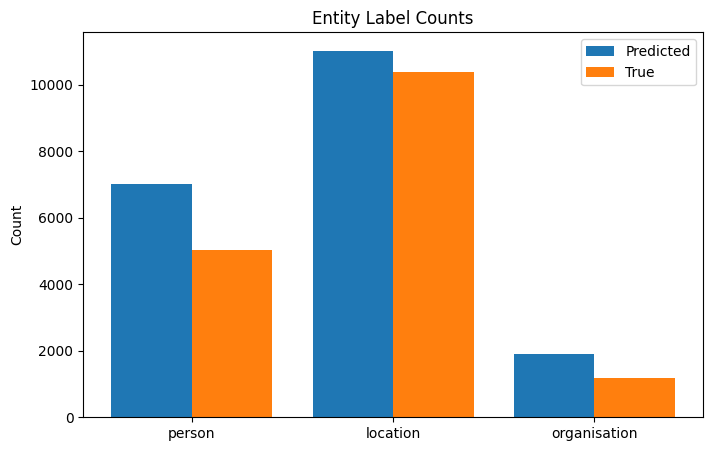

In [17]:
import matplotlib.pyplot as plt

# Merge and map predicted labels
entity_labels_count_predicted_mapped = {
    'person': entity_labels_predicted_count.get('person', 0)+entity_labels_predicted_count.get('people', 0),
    'location': entity_labels_predicted_count.get('location', 0)+ entity_labels_predicted_count.get('country',0),
    'organisation': entity_labels_predicted_count.get('sports', 0) + entity_labels_predicted_count.get('neighborhood', 0)+entity_labels_predicted_count.get('company',0),
    }

# True labels are already in the correct format
entity_labels_count_true_mapped = {
    'person': entity_labels_true_count.get('person', 0)+entity_labels_true_count.get('people', 0)+entity_labels_true_count.get('country', 0)+entity_labels_true_count.get('deceased_person', 0),
    'location': entity_labels_true_count.get('location', 0),
    'organisation': entity_labels_true_count.get('business', 0)+entity_labels_true_count.get('administrative_divison', 0)+entity_labels_true_count.get('sports', 0) + entity_labels_true_count.get('neighborhood', 0)+entity_labels_true_count.get('company',0),
    }


labels = ['person','location','organisation']
counts_pred = [entity_labels_count_predicted_mapped.get(l, 0) for l in labels]
counts_true = [entity_labels_count_true_mapped.get(l, 0) for l in labels]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, counts_pred, width=0.4, label='Predicted', align='center')
plt.bar([i + 0.4 for i in x], counts_true, width=0.4, label='True', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Count')
plt.title('Entity Label Counts')
plt.legend()
plt.show()

In [18]:
' '.join(test[7]['tokens'])

'The final deal was brokered through the major assistance of Annette L. Nazareth , an S.E.C. commissioner who once led its market regulation office , and Frank G. Zarb , the former chairman of NASD and a major presence on Wall Street and in Washington for much of his career .'

In [19]:
results[7]

['Frank G. Zarb', 'Washington', 'Wall Street', 'Annette L. Nazareth']

In [20]:
true[7]

['Frank G. Zarb', 'NASD']

In [21]:
recall_avg=[]
precision_avg=[]
common2=0
for i in range(len(results)):
    true_set=set(true[i])
    pred_set=set(results[i])
    
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m in n or n==m:
                    count+= 1
        recall = count / len(true_set) if len(true_set) > 0 else 0
        precision = count / len(pred_set) if len(pred_set) > 0 else 0
        common2 += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [22]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.9377926190476182, 0.6058585743668083)

In [23]:
def process(example):
    ner=[]
    for ent in example['relations']:
        head=ent['h']
        tail=ent['t']    
        text=head['text']
        start=head['start']
        end=head['end']
        ent_type=head['type']
        ner.append([start, end-1, ent_type, text])
        text=tail['text']
        start=tail['start']
        end=tail['end']
        ent_type=tail['type']
        ner.append([start, end-1, ent_type, text])

    example['ner'] = ner  # Add ner to the original example
    return example
processed_data = [process(example) for example in test]

In [24]:
processed_data[0]['relations']

[{'h': {'text': 'Bobby Fischer', 'start': 14, 'end': 16, 'type': 'PERSON'},
  't': {'text': 'Iceland', 'start': 35, 'end': 36, 'type': 'LOCATION'},
  'type': '/people/person/nationality'},
 {'h': {'text': 'Iceland', 'start': 35, 'end': 36, 'type': 'LOCATION'},
  't': {'text': 'Reykjavik', 'start': 33, 'end': 34, 'type': 'LOCATION'},
  'type': '/location/country/capital'},
 {'h': {'text': 'Iceland', 'start': 35, 'end': 36, 'type': 'LOCATION'},
  't': {'text': 'Reykjavik', 'start': 33, 'end': 34, 'type': 'LOCATION'},
  'type': '/location/location/contains'},
 {'h': {'text': 'Bobby Fischer', 'start': 14, 'end': 16, 'type': 'PERSON'},
  't': {'text': 'Reykjavik', 'start': 33, 'end': 34, 'type': 'LOCATION'},
  'type': '/people/deceased_person/place_of_death'}]

In [25]:
relations_true=[]
relation_labels_true_count={}
for i in range(len(processed_data)):
    temp=[]
    for j in processed_data[i]['relations']:
        s=j['type']
        rel_type = s.split('/')[3]
        temp.append([j['h']['text'], j['t']['text'], rel_type])
        if rel_type not in relation_labels_true_count:
            relation_labels_true_count[rel_type]=0
        relation_labels_true_count[rel_type]+=1
    relations_true.append(temp)  

In [26]:
relation_labels_true_count

{'nationality': 589,
 'capital': 708,
 'contains': 4059,
 'place_of_death': 136,
 'children': 42,
 'place_of_birth': 270,
 'place_lived': 612,
 'administrative_divisions': 580,
 'country': 580,
 'company': 436,
 'neighborhood_of': 394,
 'place_founded': 36,
 'founders': 63,
 'teams': 17,
 'location': 17,
 'major_shareholder_of': 33,
 'major_shareholders': 33,
 'people': 1,
 'ethnicity': 1,
 'advisors': 3,
 'religion': 5,
 'geographic_distribution': 1}

In [27]:
relations_true[0]

[['Bobby Fischer', 'Iceland', 'nationality'],
 ['Iceland', 'Reykjavik', 'capital'],
 ['Iceland', 'Reykjavik', 'contains'],
 ['Bobby Fischer', 'Reykjavik', 'place_of_death']]

In [28]:
from pair2rel import Pair2Rel

from tqdm import tqdm
model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel")
import torch

# Force usage of GPU 1
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.device = device 
relations_all=[]
labels = ['contains','includes','place_lived','nationality','company','capital','neighborhood_of','place_of_birth','country',
            'place_of_death','place_founded']
relation_labels_predicted_count={}
for i in tqdm(range(len(processed_data))):
    # required_labels = []
    # for token in processed_data[i]['tokens']:
    #     if token in rel_set:
    #         required_labels.append(token)
    
    relations = model.predict_relations(processed_data[i]['tokens'], labels, threshold=0.0, ner=processed_data[i]['ner'], top_k=1)

    sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
    temp=[]
    for item in sorted_data_desc:
        head=' '.join(item['head_text'])
        tail=' '.join(item['tail_text'])
        if head == tail:
            continue
        if item['label'] not in relation_labels_predicted_count:
            relation_labels_predicted_count[item['label']]=0
        relation_labels_predicted_count[item['label']]+=1
        temp.append([head,tail,item['label']])

    relations_all.append(temp)
        

print("Success! ✅")


/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 5000/5000 [07:34<00:00, 10.99it/s]

Success! ✅


In [36]:
relation_labels_predicted_count

{'country': 2441,
 'capital': 1663,
 'place_of_birth': 1448,
 'nationality': 2752,
 'neighborhood_of': 1236,
 'contains': 2016,
 'place_lived': 407,
 'place_of_death': 506,
 'includes': 1046,
 'company': 517,
 'place_founded': 56}

In [37]:
relation_labels_true_count

{'nationality': 589,
 'capital': 708,
 'contains': 4059,
 'place_of_death': 136,
 'children': 42,
 'place_of_birth': 270,
 'place_lived': 612,
 'administrative_divisions': 580,
 'country': 580,
 'company': 436,
 'neighborhood_of': 394,
 'place_founded': 36,
 'founders': 63,
 'teams': 17,
 'location': 17,
 'major_shareholder_of': 33,
 'major_shareholders': 33,
 'people': 1,
 'ethnicity': 1,
 'advisors': 3,
 'religion': 5,
 'geographic_distribution': 1}

In [38]:
' '.join(processed_data[10]['tokens'])

"This summer , the United States Embassy in Beirut , Lebanon , once again made its presence felt on the cultural scene by sponsoring a photo exhibition , an experimental jazz performance , a classical music concert and a visit from the Whiffenpoofs , Yale University 's a cappella singers ."

In [39]:
relations_true[10]

[['Lebanon', 'Beirut', 'contains'], ['Lebanon', 'Beirut', 'capital']]

In [40]:
relations_all[10]

[['Beirut', 'Lebanon', 'capital'], ['Lebanon', 'Beirut', 'capital']]

In [41]:
recall_avg=[]
precision_avg=[]
common=0
ours=0

for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m[0]==n[0] and m[1]==n[1] and (m[2]==n[2] or (m[2]=='administrative_divisions' and n[2]=='country') or (m[2]=='contains' and n[2]=='includes') or (m[2]=='country' and n[2]=='capital')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(pred_set) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [42]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.3588137518037519, 0.2696111111111112)

65.43

In [44]:
from pair2rel import Pair2Rel

from tqdm import tqdm
model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel")
import torch

# Force usage of GPU 1
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.device = device 
relations_all=[]
labels = ['contains','includes','place_lived','nationality','company','capital','neighborhood_of','place_of_birth','country',
            'place_of_death','place_founded']
relation_labels_predicted_count={}
for i in tqdm(range(len(processed_data))):
    # required_labels = []
    # for token in processed_data[i]['tokens']:
    #     if token in rel_set:
    #         required_labels.append(token)
    try:
    
        relations = model.predict_relations(processed_data[i]['tokens'], labels, threshold=0.0, ner=pred_ner[i], top_k=1)

        sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
        temp=[]
        for item in sorted_data_desc:
            head=' '.join(item['head_text'])
            tail=' '.join(item['tail_text'])
            if head == tail:
                continue
            if item['label'] not in relation_labels_predicted_count:
                relation_labels_predicted_count[item['label']]=0
            relation_labels_predicted_count[item['label']]+=1
            temp.append([head,tail,item['label']])

        relations_all.append(temp)
    except:
        relations_all.append([])

print("Success! ✅")


/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 5000/5000 [07:04<00:00, 11.77it/s]

Success! ✅


In [52]:
recall_avg=[]
precision_avg=[]
common=0
ours=0

for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if (m[0] in n[0] or n[0] in m[0]) and (m[1] in n[1] or n[1] in m[1]) and (m[2]==n[2] or (m[2]=='administrative_divisions' and n[2]=='country') or (m[2]=='contains' and n[2]=='includes') or (m[2]=='country' and n[2]=='capital')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(d) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [53]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.3301430772005775, 0.19016944166944294)

In [ ]:
from pair2rel import Pair2Rel

from tqdm import tqdm
model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel")
import torch

# Force usage of GPU 1
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.device = device 
relations_all=[]
labels = ['contains','includes','place_lived','nationality','company','capital','neighborhood_of','place_of_birth','country',
            'place_of_death','place_founded']
relation_labels_predicted_count={}
for i in tqdm(range(len(processed_data))):
    # required_labels = []
    # for token in processed_data[i]['tokens']:
    #     if token in rel_set:
    #         required_labels.append(token)
    
    relations = model.predict_relations(processed_data[i]['tokens'], labels, threshold=0.0, ner=processed_data[i]['ner'], top_k=2)

    sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
    temp=[]
    for item in sorted_data_desc:
        head=' '.join(item['head_text'])
        tail=' '.join(item['tail_text'])
        if head == tail:
            continue
        if item['label'] not in relation_labels_predicted_count:
            relation_labels_predicted_count[item['label']]=0
        relation_labels_predicted_count[item['label']]+=1
        temp.append([head,tail,item['label']])

    relations_all.append(temp)
        
print("Success! ✅")


/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 5000/5000 [05:23<00:00, 15.46it/s]

Success! ✅


In [54]:
recall_avg=[]
precision_avg=[]
common=0
ours=0

for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m[0]==n[0] and m[1]==n[1] and (m[2]==n[2] or (m[2]=='administrative_divisions' and n[2]=='country') or (m[2]=='contains' and n[2]=='includes') or (m[2]=='country' and n[2]=='capital')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(pred_set) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [68]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.6480175036075041, 0.2525411111111112)

In [69]:
from pair2rel import Pair2Rel

from tqdm import tqdm
model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel")
import torch

# Force usage of GPU 1
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.device = device 
relations_all=[]
labels = ['contains','includes','place_lived','nationality','company','capital','neighborhood_of','place_of_birth','country',
            'place_of_death','place_founded']
relation_labels_predicted_count={}
for i in tqdm(range(len(processed_data))):
    # required_labels = []
    # for token in processed_data[i]['tokens']:
    #     if token in rel_set:
    #         required_labels.append(token)
    
    relations = model.predict_relations(processed_data[i]['tokens'], labels, threshold=0.0, ner=processed_data[i]['ner'], top_k=3)

    sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
    temp=[]
    for item in sorted_data_desc:
        head=' '.join(item['head_text'])
        tail=' '.join(item['tail_text'])
        if head == tail:
            continue
        if item['label'] not in relation_labels_predicted_count:
            relation_labels_predicted_count[item['label']]=0
        relation_labels_predicted_count[item['label']]+=1
        temp.append([head,tail,item['label']])

    relations_all.append(temp)
        

print("Success! ✅")


/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 5000/5000 [05:14<00:00, 15.92it/s]

Success! ✅


In [70]:
recall_avg=[]
precision_avg=[]
common=0
ours=0

for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m[0]==n[0] and m[1]==n[1] and (m[2]==n[2] or (m[2]=='administrative_divisions' and n[2]=='country') or (m[2]=='contains' and n[2]=='includes') or (m[2]=='country' and n[2]=='capital')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(pred_set) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [71]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.8932503030303031, 0.23985740740740738)